Reference: https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

/opt/anaconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def load_image(image_path, mask_path):
    mask = plt.imread(mask_path)
    image = plt.imread(image_path)
    return (image, mask)

In [3]:
def scale_image(image, mask, scale_percent):
    width = int(mask.shape[1] * scale_percent / 100)
    height = int(mask.shape[0] * scale_percent / 100)
    dim = (width, height)
    scaled_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    scaled_mask = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)
    return (scaled_image, scaled_mask)

In [31]:
def extract_masked_region(image, mask):
    gray_mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)[1]
    gray_mask = cv2.cvtColor(gray_mask, cv2.COLOR_RGB2GRAY)
    label_im = label(gray_mask)
    regions = regionprops(label_im)
    properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']
    masks = []
    bbox = []
    list_of_index = []
    for num, x in enumerate(regions):
        area = x.area
        convex_area = x.convex_area
        #if (num!=0 and (area>100)):
        if area > 150:
            masks.append(regions[num].convex_image)
            bbox.append(regions[num].bbox)   
            list_of_index.append(num)
    count = len(masks)
    print("number of extracted components: {count}".format(count = count))
    
    fig, ax = plt.subplots(3, int(np.ceil(count/3)), figsize=(15,8))
    extractions = []
    for axis, box, mask in zip(ax.flatten(), bbox, masks):
        red  =  image[:,:,0][box[0]:box[2], box[1]:box[3]] * mask
        green = image[:,:,1][box[0]:box[2], box[1]:box[3]] * mask
        blue  = image[:,:,2][box[0]:box[2], box[1]:box[3]] * mask
        feature = np.dstack([red,green,blue])
        extractions.append(feature)
        axis.imshow(feature)
    return extractions

In [139]:
b_mask_path = "./Botticelli_faces.tif"
b_painting_path = "../botticelli-lippi-comparison/NG0598 Botticelli/N-0598-00-000038.tif"
f_mask_path = "./Filippino_large_faces.tif"
f_painting_path = "../botticelli-lippi-comparison/NG1124 Filippino Lippi/N-1124-00-000040.tif"

In [140]:
scale_percent = 40
b_painting, b_mask = load_image(b_painting_path, b_mask_path)
b_painting, b_mask = scale_image(b_painting, b_mask, scale_percent)

f_painting, f_mask = load_image(f_painting_path, f_mask_path)
f_painting, f_mask = scale_image(f_painting, f_mask, scale_percent)

number of extracted components: 11
number of extracted components: 21


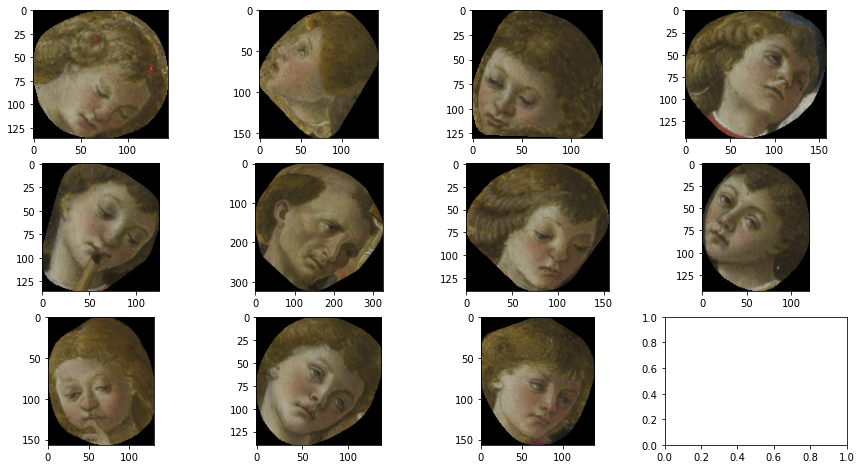

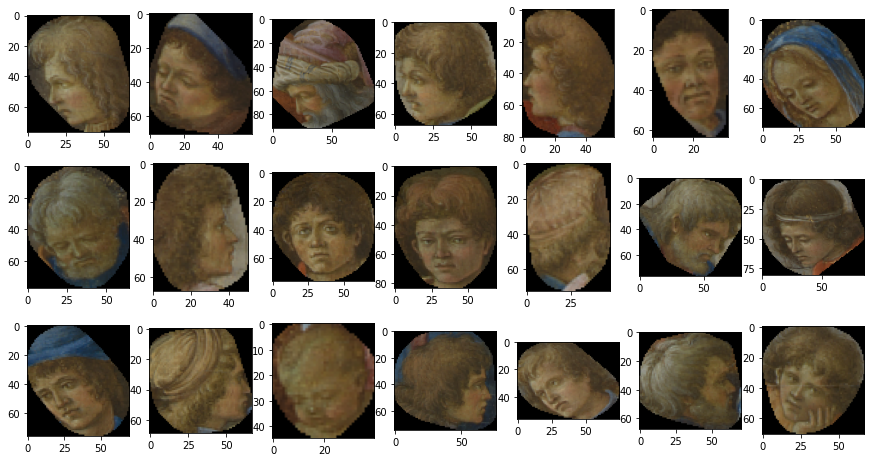

In [141]:
b_extractions = extract_masked_region(b_painting, b_mask)
f_extractions = extract_masked_region(f_painting, f_mask)

In [149]:
def append_histograms(features, feature_name, hist_dictionary):
    for i in range(len(features)):  
        feature = features[i]
        mask = cv2.threshold(feature, 1, 255, cv2.THRESH_BINARY)[1]
        mask = mask[:,:,0]
        hist = cv2.calcHist([feature], [0, 1, 2], mask, [32, 32, 32], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist)
        histograms["{feature_name} {idx}".format(feature_name = feature_name, idx = i)] = hist

In [159]:
histograms = {}
append_histograms(b_extractions, "botticelli face", histograms)
append_histograms(f_extractions, "Filippino face", histograms)

In [151]:
def img_to_sig(img):
    sig = np.empty((img.size, 4), dtype=np.float32)
    idx = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                sig[idx] = np.array([img[i,j,k],i,j,k])
                idx += 1
    return sig

In [170]:
img1 = histograms["botticelli face 2"]
img2 = histograms["Filippino face 5"]

In [172]:
sig1 = img_to_sig(img1)
sig2 = img_to_sig(img2)

In [174]:
distance, lowerbound, flow_matrix = cv2.EMD(sig1, sig2, cv2.DIST_L1, lowerBound=0)

In [175]:
distance

0.38971787691116333

In [186]:
# split the image into its respective channels, then initialize
# the tuple of channel names along with our figure for plotting
def plot_histogram(image, title):
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    mask = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)[1]
    mask = mask[:,:,0]
# loop over the image channels
# create a histogram for the current channel and plot it
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], mask, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        plt.plot(hist, color=color)
        plt.xlim([0, 32])

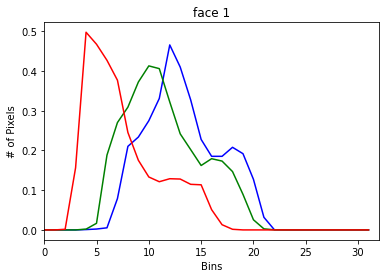

In [187]:
plot_histogram(b_extractions[0], "face 1")

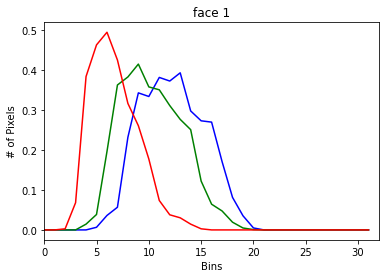

In [188]:
plot_histogram(f_extractions[0], "face 1")